### <center>Digits clustering</center>

In [1]:
from clust_utils import *

import numpy as np
import pandas as pd

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 80)

import gc
import pickle

from sklearn import datasets
from sklearn.datasets import fetch_openml

from sklearn.cluster import AgglomerativeClustering, KMeans

from sklearn.metrics import (homogeneity_score, completeness_score,
                             v_measure_score, silhouette_score) 
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from scipy.stats import mode

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
np.random.seed(1)

### Load data

In [2]:
digits = datasets.load_digits()

In [3]:
list(digits)

['data', 'target', 'target_names', 'images', 'DESCR']

In [4]:
X = digits.data
y = digits.target

X.shape
y.shape

(1797, 64)

(1797,)

In [5]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

##### Visualization of 10 images

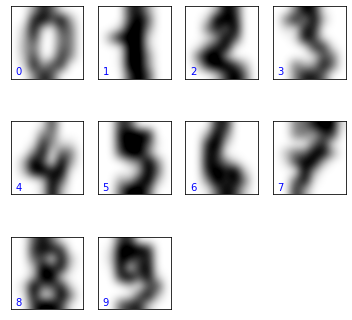

In [6]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])

    ax.imshow(
        digits.images[i],
        cmap=plt.cm.binary,
        clim=(0, 14),
        interpolation='bicubic')

    # target
    ax.text(0, 7, str(digits.target[i]), color='blue')

pass;

### Clustering and quality assessment

`AgglomerativeClustering`: 

In [7]:
agc = AgglomerativeClustering(n_clusters=10)
agc_pred = agc.fit_predict(X)
X_clust_agc = np.column_stack([X, agc_pred])

`KMeans`:

In [8]:
kmeans = KMeans(n_clusters=10, n_init=100, n_jobs=-1, 
                random_state=42).fit(X)
km_pred = kmeans.predict(X)
X_clust_km = np.column_stack([X, km_pred])

In [9]:
target_agc = X_clust_agc[:, -1]
agc_centers = group_mean(X_clust_agc, target_agc)[:, :-1]

target_km = X_clust_km[:, -1]
km_centers = group_mean(X_clust_km, target_km)[:, :-1]

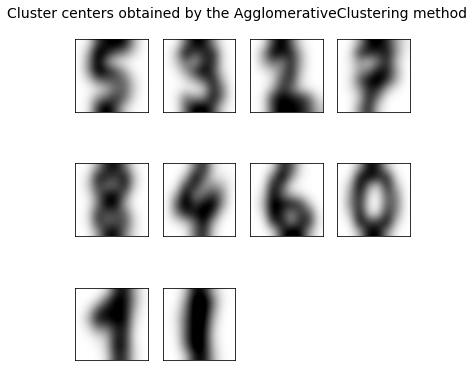

In [10]:
plot_digits(
    agc_centers,
    suptitle='Cluster centers obtained by the AgglomerativeClustering method')

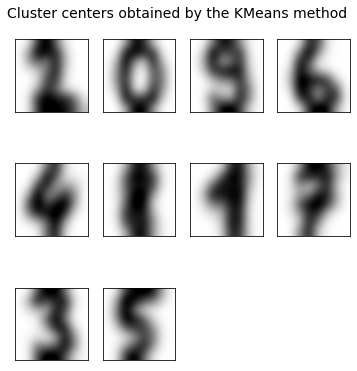

In [11]:
plot_digits(
    km_centers,
    suptitle='Cluster centers obtained by the KMeans method')

Change parameters `n_init` and `max_iter`:

In [12]:
kmeans = KMeans(
    n_clusters=10, n_init=500, max_iter=400, n_jobs=-1, random_state=42).fit(X)
km_pred = kmeans.predict(X)
centroids = kmeans.cluster_centers_

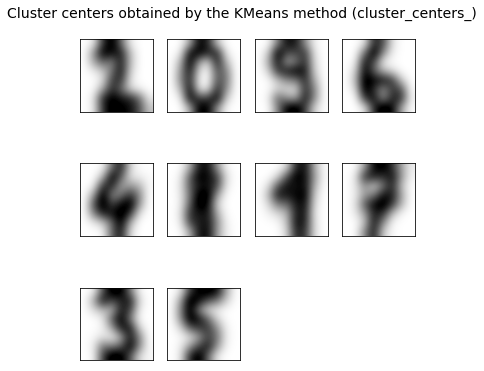

In [13]:
plot_digits(
    centroids, 
    suptitle='Cluster centers obtained by the KMeans method (cluster_centers_)')

`KMeans` algorithm does not identify clusters so the class labels will be shuffled. Let's use `mode` function (package `scipy.stats`) to get an array of the modal (most common) value in the passed array and create `confusion_matrix`. 

In [14]:
labels = np.zeros_like(km_pred)
for i in range(10):
    mask = (km_pred == i)
    labels[mask] = mode(y[mask])[0]

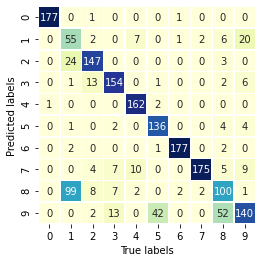

In [15]:
mat = confusion_matrix(y, labels)
sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    fmt='d',
    cbar=False,
    linewidths=.4,
    cmap="YlGnBu",
    xticklabels=digits.target_names,
    yticklabels=digits.target_names)
plt.xlabel('True labels')
plt.ylabel('Predicted labels');

Clustering metrics from `sklearn` library to evaluate the quality of clustering: `silhouette_score`, `homogeneity_score`, `completeness_score`, `v_measure_score`. 

Let's obtain a partition of the array X into 𝐾 clusters (from 2 to 20) by each of the two methods and then calculate metrics. 

In [16]:
silhouette_km, homogeneity_km, completeness_km, v_ms_km = get_metrics(
    2, 21, KMeans, X, y)

silhouette_agc, homogeneity_agc, completeness_agc, v_ms_agc = get_metrics(
    2, 21, AgglomerativeClustering, X, y)

In [17]:
gc.collect()

52745

**`silhouette_score` visualization:**

In [18]:
num_clusters = list(range(2, 21))

data_s = pd.DataFrame({
    "Silhouette KMeans": silhouette_km,
    "Silhouette Agc": silhouette_agc,
    "Number of clusters": num_clusters
})
data_s_res = pd.melt(data_s, ['Number of clusters'])
data_s_res.columns = ['Number of clusters', 'Silhouette', 'Values']

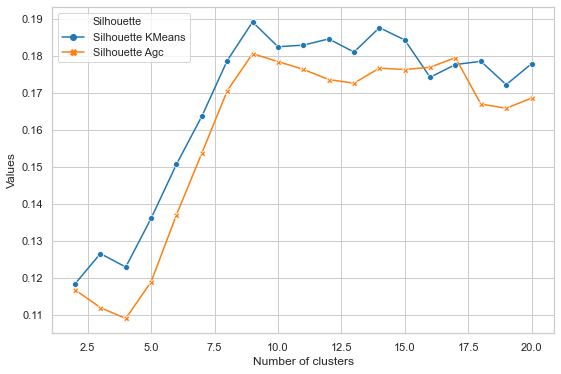

In [19]:
plot_scores(data_s_res, hue="Silhouette", style="Silhouette")

In [20]:
print("Max silhouette_score KMeans: ")
data_s.iloc[data_s['Silhouette KMeans'].idxmax(), [0,2]]

print("Max silhouette_score AgglomerativeClustering: ")
data_s.iloc[data_s['Silhouette Agc'].idxmax(), [1,2]]

Max silhouette_score KMeans: 


Silhouette KMeans     0.189204
Number of clusters    9.000000
Name: 7, dtype: float64

Max silhouette_score AgglomerativeClustering: 


Silhouette Agc        0.18062
Number of clusters    9.00000
Name: 7, dtype: float64

**`v_measure_score` visualization:**

In [21]:
data_vm = pd.DataFrame({
    "V_measure KMeans": v_ms_km,
    "V_measure Agc": v_ms_agc,
    "Number of clusters": num_clusters
})
data_vm_res = pd.melt(data_vm, ['Number of clusters'])
data_vm_res.columns = ['Number of clusters', 'V_measure', 'Values']

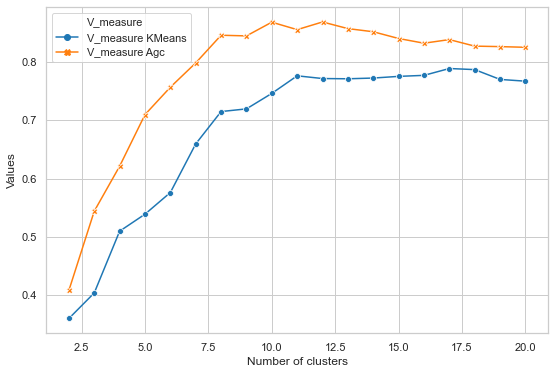

In [22]:
plot_scores(data_vm_res, hue="V_measure", style="V_measure")

In [23]:
print("Max v_measure_score KMeans: ")
data_vm.iloc[data_vm['V_measure KMeans'].idxmax(), [0,2]]

print("Max v_measure_score AgglomerativeClustering: ")
data_vm.iloc[data_vm['V_measure Agc'].idxmax(), [1,2]]

Max v_measure_score KMeans: 


V_measure KMeans       0.788716
Number of clusters    17.000000
Name: 15, dtype: float64

Max v_measure_score AgglomerativeClustering: 


V_measure Agc          0.868549
Number of clusters    12.000000
Name: 10, dtype: float64

In [24]:
gc.collect()

6592

`homogeneity_score` and `completeness_score` for number of clusters from 2 to 20:

In [25]:
print('\nMax clustering metrics: \n')

data_all = pd.DataFrame({
    "Homogeneity KMeans": homogeneity_km,
    "Homogeneity Agc": homogeneity_agc,
    "Completeness KMeans": completeness_km,
    "Completeness Agc": completeness_agc,
    "Number of clusters": num_clusters
})
print(data_all.iloc[data_all['Homogeneity KMeans'].idxmax(), [0, -1]])
print(data_all.iloc[data_all['Homogeneity Agc'].idxmax(), [1, -1]])
print(data_all.iloc[data_all['Completeness KMeans'].idxmax(), [2, -1]])
print(data_all.iloc[data_all['Completeness Agc'].idxmax(), [3, -1]])

hom_km10 = float(
    data_all['Homogeneity KMeans'][data_all['Number of clusters'] == 10])
hom_agc10 = float(
    data_all['Homogeneity Agc'][data_all['Number of clusters'] == 10])
comp_km10 = float(data_all['Completeness KMeans'][data_all[
    'Number of clusters'] == 10])
comp_agc10 = float(
    data_all['Completeness Agc'][data_all['Number of clusters'] == 10])

print('\nHomogeneity_score for 10 clusters (KMeans): ' +
      str(hom_km10))
print(
    'Homogeneity_score for 10 clusters (AgglomerativeClustering): '
    + str(hom_agc10))
print('Completeness_score for 10 clusters (KMeans): ' +
      str(comp_km10))
print(
    'Completeness_score for 10 clusters (AgglomerativeClustering): '
    + str(comp_agc10))


Max clustering metrics: 

Homogeneity KMeans     0.87764
Number of clusters    18.00000
Name: 16, dtype: float64
Homogeneity Agc        0.929128
Number of clusters    20.000000
Name: 18, dtype: float64
Completeness KMeans    0.847115
Number of clusters     2.000000
Name: 0, dtype: float64
Completeness Agc      0.974751
Number of clusters    2.000000
Name: 0, dtype: float64

Homogeneity_score for 10 clusters (KMeans): 0.7416993516796566
Homogeneity_score for 10 clusters (AgglomerativeClustering): 0.8575128719504723
Completeness_score for 10 clusters (KMeans): 0.750435371648251
Completeness_score for 10 clusters (AgglomerativeClustering): 0.8790955851724198


In [26]:
gc.collect()

20

### Dimensionality Reduction

#### SVD

In [27]:
silhouette_km_reduced, v_ms_km_reduced = dim_reduction(TruncatedSVD, KMeans,
                                                       X, y)
silhouette_agc_reduced, v_ms_agc_reduced = dim_reduction(
    TruncatedSVD, AgglomerativeClustering, X, y)

In [51]:
num_features = [2, 5, 10, 20]

sh_km10 = float(
    data_s['Silhouette KMeans'][data_s['Number of clusters'] == 10])
sh_agc10 = float(
    data_s['Silhouette Agc'][data_s['Number of clusters'] == 10])

vm_km10 = float(
    data_vm['V_measure KMeans'][data_vm['Number of clusters'] == 10])
vm_agc10 = float(
    data_vm['V_measure Agc'][data_vm['Number of clusters'] == 10])

data_all = pd.DataFrame({
    "Number of features": num_features,
    "Dim. Reduction": 'SVD',
    "Silhouette KMeans": silhouette_km_reduced,
    "Silhouette Agc": silhouette_agc_reduced,
    "V_measure KMeans": v_ms_km_reduced,
    "V_measure Agc": v_ms_agc_reduced
})

data_all = data_all.append({
    'Number of features': 64,
    "Dim. Reduction": 'SVD',
    'Silhouette KMeans': sh_km10,
    'Silhouette Agc': sh_agc10,
    'V_measure KMeans': vm_km10,
    'V_measure Agc': vm_agc10,
},
    ignore_index=True)

data_all

,Number of features,Dim. Reduction,Silhouette KMeans,Silhouette Agc,V_measure KMeans,V_measure Agc
0,2,SVD,0.349166,0.280817,0.348443,0.333719
1,5,SVD,0.312222,0.272741,0.636185,0.675604
2,10,SVD,0.263172,0.250709,0.721223,0.825975
3,20,SVD,0.212592,0.197132,0.740663,0.814388
4,64,SVD,0.182502,0.178497,0.746042,0.868170


#### t-SNE algorithm (2 features by default)

In [29]:
tsne = TSNE(init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

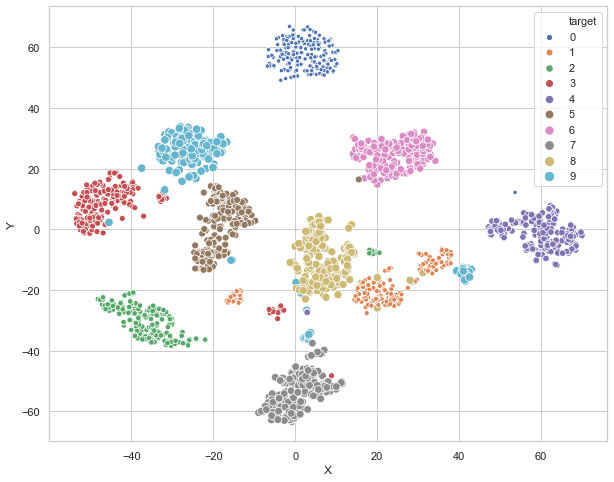

In [30]:
dtsne = pd.DataFrame()
dtsne['X'] = X_tsne[:, 0]
dtsne['Y'] = X_tsne[:, 1]
dtsne['target'] = y
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="X", 
    y="Y", 
    hue='target', 
    palette=sns.color_palette(), 
    data=dtsne, 
    legend='full', 
    size='target');

In [31]:
# AgglomerativeClustering
agc_tsne = AgglomerativeClustering(n_clusters=10)
agc_pred_tsne = agc_tsne.fit_predict(X_tsne)

silh_agc_tsne = silhouette_score(X_tsne, agc_pred_tsne)
v_ms_agc_tsne = v_measure_score(y, agc_pred_tsne)

# KMeans
kmeans_tsne = KMeans(
    n_clusters=10, n_init=100, n_jobs=-1, random_state=42).fit(X_tsne)
km_pred_tsne = kmeans_tsne.predict(X_tsne)

silh_km_tsne = silhouette_score(X_tsne, km_pred_tsne)
v_ms_km_tsne = v_measure_score(y, km_pred_tsne) 

In [52]:
data_all = data_all.append({
    'Number of features': '2 (t-SNE)',
    "Dim. Reduction": 't-SNE',
    'Silhouette KMeans': silh_km_tsne,
    'Silhouette Agc': silh_agc_tsne,
    'V_measure KMeans': v_ms_km_tsne,
    'V_measure KMeans': v_ms_agc_tsne,
},
    ignore_index=True)

data_all['Number of features'] = data_all['Number of features'].astype(str)
data_all = data_all.set_index(['Number of features'])

data_all

,Dim. Reduction,Silhouette KMeans,Silhouette Agc,V_measure KMeans,V_measure Agc
Number of features,,,,,
2,SVD,0.349166,0.280817,0.348443,0.333719
5,SVD,0.312222,0.272741,0.636185,0.675604
10,SVD,0.263172,0.250709,0.721223,0.825975
20,SVD,0.212592,0.197132,0.740663,0.814388
64,SVD,0.182502,0.178497,0.746042,0.868170
2 (t-SNE),t-SNE,0.626647,0.630045,0.894317,0.911422


In [54]:
data_all['Silhouette KMeans'].idxmax()
data_all['Silhouette Agc'].idxmax()
data_all['V_measure KMeans'].idxmax()
data_all['V_measure KMeans'].idxmax()

'2 (t-SNE)'

'2 (t-SNE)'

'2 (t-SNE)'

'2 (t-SNE)'

Cluster centers for the best `silhouette_score` and `v_measure_score`:  

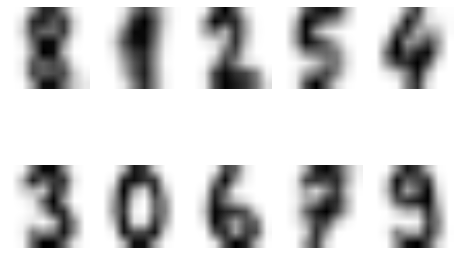

In [56]:
fig, ax = plt.subplots(2,5, figsize=(8,5))
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i in range(10):
    center = np.mean(X[agc_pred_tsne ==i, :], axis=0).reshape(8,8)
    ax[i//5, i%5].imshow(center, cmap=plt.cm.gray_r, interpolation='bilinear')
    ax[i//5, i%5].imshow(center, cmap=plt.cm.gray_r, interpolation='bilinear')
    ax[i//5, i%5].set_axis_off()
pass;    